In [19]:
from matplotlib.colors import ListedColormap
from numpy.random import seed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
class AdalineGD(object):
    """Классификация на основе ADALINE"""
    def __init__(self, eta=0.01, n_iter=10):
        self.eta = eta
        self.n_iter = n_iter
    
    def fit(self, X, y):
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []
        
        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y-output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self
    
    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def activation(self, X):
        return self.net_input(X)
    
    def predict(self, X):
        return np.where(self.activation(X) >= 0.0, 1, -1)

In [4]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'

In [5]:
df = pd.read_csv(url, header=None)

In [6]:
y = df.iloc[0:100, 4].values

In [7]:
y = np.where(y=='Iris-setosa', -1, 1)

In [8]:
X = df.iloc[0:100, [0,2]].values

In [9]:
def plot_decision_regions(X, y, classifier, resolution=0.02):
    markers = ('s','x','o','^','v')
    colors = ('red','blue','ligthgreen', 'gray','black')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y== cl, 0], y = X[y==cl,1], alpha=0.8, c=cmap(idx), marker=markers[idx], label=cl)

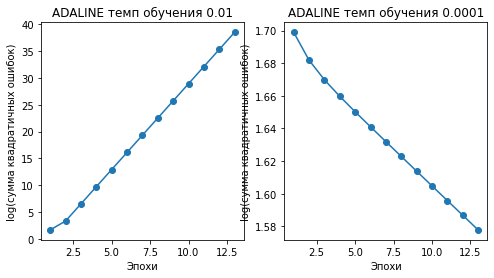

In [13]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (8, 4))
ada1 = AdalineGD(n_iter=13, eta=0.01).fit(X,y)
ax[0].plot(range(1, len(ada1.cost_)+1), np.log10(ada1.cost_), marker='o')
ax[0].set_xlabel('Эпохи')
ax[0].set_ylabel('log(сумма квадратичных ошибок)')
ax[0].set_title('ADALINE темп обучения 0.01')
ada2 = AdalineGD(n_iter=13, eta=0.0001).fit(X,y)
ax[1].plot(range(1, len(ada2.cost_)+1), np.log10(ada2.cost_), marker='o')
ax[1].set_xlabel('Эпохи')
ax[1].set_ylabel('log(сумма квадратичных ошибок)')
ax[1].set_title('ADALINE темп обучения 0.0001')
plt.show()

In [14]:
X_std = np.copy(X)

In [15]:
X_std[:,0] = (X[:,0] - X[:, 0].mean())/ X[:,0].std()
X_std[:,1] = (X[:,1] - X[:, 1].mean())/ X[:,1].std()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


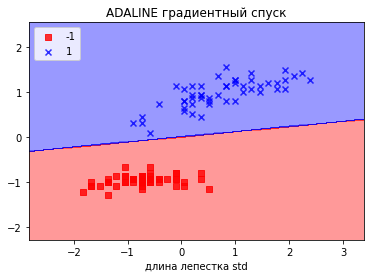

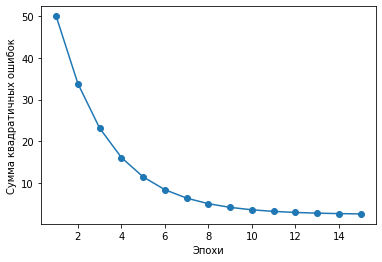

In [16]:
ada = AdalineGD(n_iter=15, eta = 0.01)
ada.fit(X_std, y)
plot_decision_regions(X_std, y, classifier=ada)
plt.title('ADALINE градиентный спуск')
plt.xlabel('длина чашелистого std')
plt.xlabel('длина лепестка std')
plt.legend(loc='upper left')
plt.show()
plt.plot(range(1, len(ada.cost_)+1), ada.cost_, marker='o')
plt.xlabel('Эпохи')
plt.ylabel('Сумма квадратичных ошибок')
plt.show()

In [24]:
class AdalineSGD(object):
    """Классификация на основе ADALINE"""
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        if random_state:
            seed(random_state)
    
    def fit(self, X, y):
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X,y)
            cost = []
            for xi, target in zip(X,y):
                cost.append(self._update_weigths(xi, target))
            avg_cost = sum(cost)/len(y)
            self.cost_.append(avg_cost)
        return self
    
    def partial_fit(self, X, y):
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0]>1:
            for xi, target in zip(X,y):
                self._update_weigths(xi, target)
        else:
            self._update_weigths(X, y)
        return self
        
    def _shuffle(self, X, y):
        r = np.random.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        self.w_ = np.zeros(1 + m)
        self.w_initialized = True
        
    def _update_weigths(self, xi, target):
        output = self.net_input(xi)
        errors = (target-output)
        self.w_[1:] += self.eta * xi.dot(errors)
        self.w_[0] += self.eta * errors
        cost = 0.5 * errors**2
        self.cost_.append(cost)
        return cost
        
    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def activation(self, X):
        return self.net_input(X)
    
    def predict(self, X):
        return np.where(self.activation(X) >= 0.0, 1, -1)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


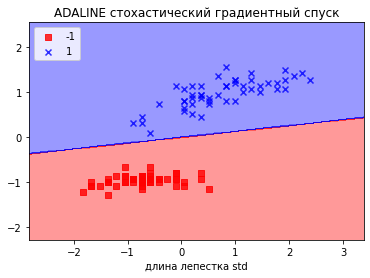

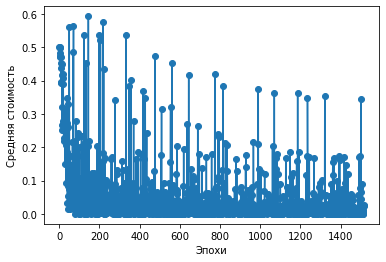

In [25]:
ada = AdalineSGD(n_iter=15, eta = 0.01, random_state=1)
ada.fit(X_std, y)
plot_decision_regions(X_std, y, classifier=ada)
plt.title('ADALINE стохастический градиентный спуск')
plt.xlabel('длина чашелистого std')
plt.xlabel('длина лепестка std')
plt.legend(loc='upper left')
plt.show()
plt.plot(range(1, len(ada.cost_)+1), ada.cost_, marker='o')
plt.xlabel('Эпохи')
plt.ylabel('Средняя стоимость')
plt.show()